In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def read_data(path):
    data = np.load(path)
    labels = data.T[-1]
    data = np.delete(data.T, -1, 0)
    
    return data.T, labels
x_train, y_train = read_data("fashion_train.npy")
x_train = np.load("pca_59d_lda_4d_train.npy").T
_ , y_test = read_data("fashion_test.npy")
x_test = np.load('pca_59d_lda_4d_test.npy').T

In [6]:
def calc_gausian_params(X,Y):
    means = {}
    covariance_mats = {}
    priors = {}
    classes = np.unique(Y)
    for clss in classes:
        class_data = X[np.where(Y == clss)]
        means[clss] = np.mean(class_data,axis = 0)
        covariance_mats[clss] = np.cov(class_data,rowvar=False)
        priors[clss] = class_data.shape[0]/X.shape[0]
    return means, covariance_mats, priors
    

In [7]:
def calc_gaussian_dist(x,mu,cov):
    scalar = (1. / ((2 * np.pi) **
                    (x.shape[0] / 2.))
             ) * (1 / np.sqrt(np.linalg.det(cov)))
    x_sub_mu = np.subtract(x, mu)
    return scalar * np.exp(-np.dot(np.dot(x_sub_mu, np.linalg.inv(cov)), x_sub_mu.T) / 2.)

In [8]:
def lda_predict(X,classes,means,cov_mats,priors):
    
    gaussian_likelihoods = []
    for x in X:
        row_vals = []
        for clss in classes:
            val = priors[clss]*calc_gaussian_dist(x,means[clss],cov_mats[clss])
            row_vals.append(val)
        gaussian_likelihoods.append(row_vals)
    gaussian_likelihoods = np.asarray(gaussian_likelihoods)
    predictions = np.argmax(gaussian_likelihoods, axis=1)
    return predictions
        

In [11]:
def lda_classifier(x_train,y_train,x_val):
    
    means,cov_mats,priors = calc_gausian_params(x_train,y_train)
    
    preds = lda_predict(x_val,[0,1,2,3,4],means,cov_mats,priors)
    return preds

In [15]:
def calc_confusion_matrix(true, pred):
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

In [16]:
def plot_confusion_matrix(mat_confusion,to_save = False, filename = ""):
    mat_confusion = np.intc(mat_confusion)
    ax = sns.heatmap(mat_confusion,  annot=True, fmt='d', cbar=True, square=True)
    if not to_save: 
        plt.show()
    else:
        plt.savefig(filename)


In [17]:
def calc_precision(confusion_mat):
    true_positive_dict = {}
    false_positive_dict = {}
    for i in range(confusion_mat.shape[1]):
        true_positive_dict[i] = 0
        false_positive_dict[i] = 0
        for j in range(confusion_mat.shape[0]):
            if i == j :
                true_positive_dict[i] += confusion_mat[i,j]
            else:
                false_positive_dict[i] += confusion_mat[i,j]
    precision_dict = {}
    for i in range(confusion_mat.shape[1]):
        precision_dict[i] = true_positive_dict[i]/( true_positive_dict[i] + false_positive_dict[i])  
    return precision_dict
            

In [18]:
def calc_recall(confusion_mat):
    true_positive_dict = {}
    false_negative_dict = {}
    for i in range(confusion_mat.shape[0]):
        true_positive_dict[i] = 0
        false_negative_dict[i] = 0
        for j in range(confusion_mat.shape[1]):
            if i == j :
                true_positive_dict[i] += confusion_mat[j,i] 
            else:
                false_negative_dict[i] += confusion_mat[j,i]
    recall_dict = {}
    for i in range(confusion_mat.shape[0]):
        recall_dict[i] = true_positive_dict[i]/(true_positive_dict[i] + false_negative_dict[i])
    return recall_dict
                

In [19]:
def calc_f1_score(prec_dict , recall_dict ):
    f1_dict = {}
    for i in range(len(prec_dict)):
        f1_dict[i] = (2 * prec_dict[i] * recall_dict[i] ) / (prec_dict[i] + recall_dict[i])
    return f1_dict

In [20]:
def calc_for_mat(measure_dict):
    return sum(measure_dict.values())/len(measure_dict)

In [21]:
def avg_accuracy(confmat):
    accuracy = []
    for clss in range(5):
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        for i in range(confmat.shape[0]):
            for j in range(confmat.shape[1]):
                if i == clss and j == clss:
                    tp = confmat[i,j]
                elif i == clss:
                    fp += confmat[i,j]
                elif j == clss:
                    fn += confmat[i,j]
                else:
                    tn += confmat[i,j]
        #print(tp, tn, fn, fp)
        accuracy.append((tp + tn) / (tp + tn + fp + fn))
    return(sum(accuracy)/confmat.shape[0])

In [24]:
def kfold(k):
    f1_sum = 0
    accuracy_sum = 0
    conf_mats = np.zeros((5,5))
    for i in range(k):
        
        datacopy = x_train.copy()
        labelcopy = y_train.copy()
        validtion = datacopy[ int( i * len( datacopy ) / k ) : int( ( i + 1 ) * len( datacopy ) / k ), : ]
        validation_label = labelcopy[ int( i * len( datacopy ) / k ) : int( ( i + 1 ) * len( datacopy ) / k)]
        train_data = np.delete( datacopy , list( range( int( i * len( datacopy ) / k ) ,
                                                       int( ( i + 1 ) * len( datacopy ) / k ) ) ), axis=0 )
        train_label = np.delete( labelcopy , list( range( int( i * len( datacopy ) / k ),
                                                          int( ( i + 1 ) * len( datacopy ) / k ) ) ), axis=0)
        preds = lda_classifier(train_data,train_label,validtion)
    
        confusion_mat = calc_confusion_matrix(validation_label,preds)
        conf_mats += confusion_mat
    return conf_mats


In [26]:
con_mat= kfold(10)


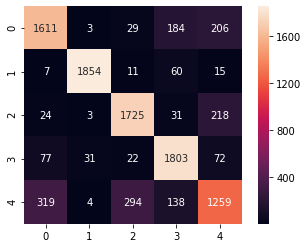

In [27]:
plot_confusion_matrix(con_mat,to_save = True, filename = 'gaussian_confusion_mat_train')

In [28]:
prec_dict = calc_precision(con_mat)

In [29]:
recall_dict = calc_recall(con_mat)

In [30]:
f1_dict = calc_f1_score(prec_dict,recall_dict)

In [31]:
calc_for_mat(f1_dict)

0.8242962661916253

In [32]:
calc_for_mat(prec_dict)

0.8262208322196501

In [33]:
calc_for_mat(recall_dict)

0.8245401946735085

In [35]:
avg_accuracy(con_mat)

0.9300799999999999

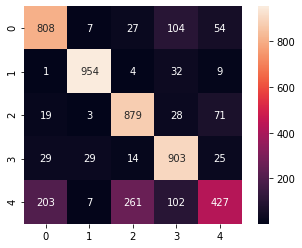

In [36]:
test_preds = lda_classifier(x_train,y_train,x_test)
confusion_mat = calc_confusion_matrix(y_test,test_preds)
plot_confusion_matrix(confusion_mat,to_save = True, filename = 'gaussian_confusion_mat_test')


In [37]:
prec_dict = calc_precision(confusion_mat)

In [38]:
recall_dict = calc_recall(confusion_mat)
f1_dict = calc_f1_score(prec_dict,recall_dict)
calc_for_mat(f1_dict)

0.7828291974638045

In [39]:
calc_for_mat(recall_dict)

0.7918320669284025

In [40]:
calc_for_mat(prec_dict)

0.7942

In [41]:
avg_accuracy(confusion_mat)

0.91768